<a href="https://colab.research.google.com/github/UzunDemir/Neural_networks_and_NLP/blob/main/TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача классификации текста с использованием архитектуры LSTM.

Датасет IMDB Dataset of 50K Movie Reviews

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

**review**: отзыв

**sentiment**: позитивный или негативный


In [1]:
!pip install kaggle

In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 70% 18.0M/25.7M [00:00<00:00, 60.6MB/s]
100% 25.7M/25.7M [00:00<00:00, 71.7MB/s]


In [4]:
import zipfile
import os

# Путь к вашему архиву fake-news.zip
zip_file = '/content/imdb-dataset-of-50k-movie-reviews.zip'

# Папка, куда вы хотите распаковать файлы
extract_dir = '/content/imdb-dataset-of-50k-movie-reviews'

# Распаковка архива
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Вывод содержимого распакованной папки
os.listdir(extract_dir)


['IMDB Dataset.csv']

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# Загружаем стоп-слова из библиотеки NLTK
stop_words = set(stopwords.words('english'))

In [7]:
!ls

imdb-dataset-of-50k-movie-reviews  imdb-dataset-of-50k-movie-reviews.zip  sample_data


In [8]:
# Считываем датасет
df = pd.read_csv(r'/content/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
# Проверяем на наличие null-значений
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [10]:
# Удаляем null-значения, если есть
# df_cleaned = df.dropna()
# df_cleaned

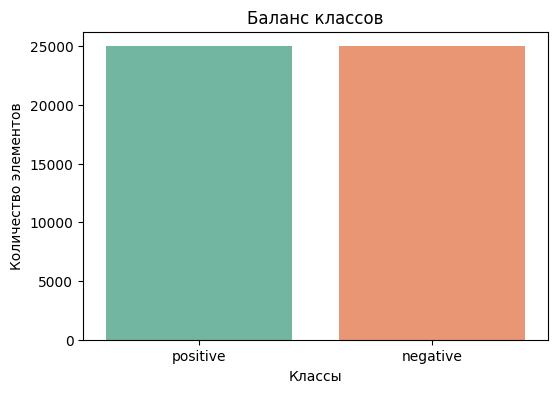

In [11]:
# Количество элементов каждого класса
class_counts = df['sentiment'].value_counts()

# Визуализация графика баланса классов
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, hue='sentiment', palette='Set2', legend=False)
plt.title('Баланс классов')
plt.xlabel('Классы')
plt.ylabel('Количество элементов')
plt.show()

In [12]:
def preprocess_text(text):
    # Удаляем знаки препинания
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Приводим к нижнему регистру
    text = text.lower()

    # Токенизация текста
    tokens = word_tokenize(text)

    # Удаляем стоп-слова
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Удаляем числа и другие символы
    tokens = [word for word in tokens if word.isalpha()]

    # Склеиваем токены обратно в строку
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [13]:
def preprocess_dataframe(dataframe, text_column):
    # Применяем preprocess_text ко всем значениям в указанной колонке
    dataframe[text_column] = dataframe[text_column].apply(preprocess_text)

    return dataframe

In [14]:
preprocess_dataframe(df, 'review')

,review,sentiment
0,one reviewers mentioned watching oz episode yo...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,im going disagree previous comment side maltin...,negative


In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'].tolist())

In [16]:
# Получение словаря
word_index = tokenizer.word_index

In [17]:
sequences = tokenizer.texts_to_sequences(df['review'].tolist())
data = sequence.pad_sequences(sequences)
print(data)

[[    0     0     0 ...  1078  3834   387]
 [    0     0     0 ...  1759    14   126]
 [    0     0     0 ...    53    11   227]
 ...
 [    0     0     0 ... 20443 23155  5824]
 [    0     0     0 ... 12076  4123   591]
 [    0     0     0 ...  4053   661     2]]


In [18]:
# Кодируем категориальный признак
category_mapping = {'positive': 1, 'negative': 0}

In [19]:
df['label'] = df['sentiment'].replace(category_mapping)

In [20]:
df

,review,sentiment,label
0,one reviewers mentioned watching oz episode yo...,positive,1
1,wonderful little production br br filming tech...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,basically theres family little boy jake thinks...,negative,0
4,petter matteis love time money visually stunni...,positive,1
...,...,...,...
49995,thought movie right good job wasnt creative or...,positive,1
49996,bad plot bad dialogue bad acting idiotic direc...,negative,0
49997,catholic taught parochial elementary schools n...,negative,0
49998,im going disagree previous comment side maltin...,negative,0


In [21]:
# Разделение на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(data, df['label'], test_size=0.20, random_state=42)

# LSTM

In [22]:
vocab_size = len(tokenizer.word_index) + 1  # добавляем 1, так как индексы начинаются с 1
max_length = max(len(seq) for seq in sequences)

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dense(1, activation='sigmoid')  # для бинарной классификации
])

# Используем early_stop, который прекращает обучение, когда validation loss больше не улучшается patience=2
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=1, validation_split=0.2, batch_size=30, shuffle=True, callbacks=[early_stop]) #epochs=10

1067/1067 [==============================] - 1773s 2s/step - loss: 0.3463 - accuracy: 0.8521 - val_loss: 0.2810 - val_accuracy: 0.8869


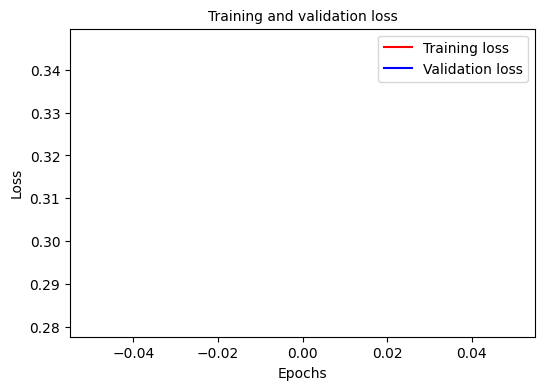

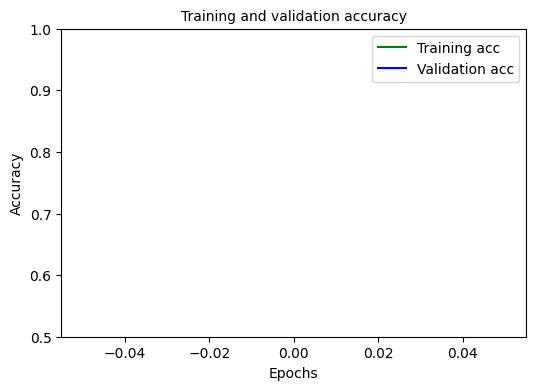

In [24]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Loss', size=10)
plt.legend(prop={'size': 10})
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Accuracy', size=10)
plt.legend(prop={'size': 10})
plt.ylim((0.5,1))
plt.show()

313/313 [==============================] - 70s 222ms/step
Accuracy: 0.8933
F1 Score: 0.8942202835332608
ROC AUC Score: 0.9563513844182281


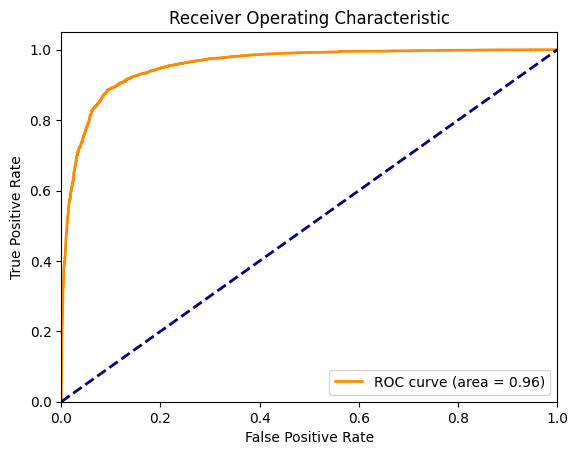

In [25]:
# Получаем предсказания
y_pred = model.predict(X_test)

# Округляем вероятности до 0 или 1
y_pred_binary = np.round(y_pred)

# Оцениваем производительность модели
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

# Выводим результаты
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Строим ROC-кривую
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()